In [158]:
import tensorflow as tf
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, stft, istft
import matplotlib.pyplot as plt
import librosa
import librosa.display
from misceallaneous import getWavFileAsNpArray, displaySpectrogram
from IPython.display import Audio

samplerate = 12000
nperseg = 1024

clean0 = getWavFileAsNpArray("../dataset_2/clean/p1.wav")
white0 = getWavFileAsNpArray("../dataset_2/white/p1.wav")
clean0 = np.array(clean0, dtype="int32")
white0 = np.array(white0, dtype="int32")


min_clean = np.min(clean0)
max_clean = np.max(clean0)
clean = (clean0 - min_clean)/(max_clean-min_clean)

min_white = np.min(white0)
max_white = np.max(white0)
white = (white0 - min_white)/(max_white-min_white)


In [159]:
clean_split = []
white_split = []

samples_length = nperseg

for i in range(0, clean.shape[0]-samples_length, samples_length):
    clean_split.append(clean[i:i+samples_length])
    white_split.append(white[i:i+samples_length])
clean_split = np.array(clean_split)
white_split = np.array(white_split)

c, t, Cxx_test = stft(np.array((clean_split[0]*(max_clean-min_clean)) + min_clean), fs=samplerate, nperseg=nperseg)
c, t, Vxx_test = stft(np.array((white_split[0]*(max_white-min_white)) + min_white), fs=samplerate, nperseg=nperseg)
print(clean_split.shape)
print(white_split.shape)

(10659, 1024)
(10659, 1024)


In [162]:
def generator(size):
    inputs = tf.keras.Input(shape=(size,))
    x1 = tf.keras.layers.Dense(size, activation="relu")(inputs)
    x2 = tf.keras.layers.Dense(int(size*0.5), activation="relu")(x1)
    x3 = tf.keras.layers.Dense(int(size*0.2), activation="relu")(x2)
    x4 = tf.keras.layers.Dense(int(size*0.5), activation="relu")(x3)
    outputs = tf.keras.layers.Dense(size, activation="linear")(x4)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="generator")
    model.summary()
    model.compile(optimizer='adam', loss='bce', metrics=['accuracy'])
    return model

def skip_generator(size):
    inputs = tf.keras.Input(shape=(size,))
    x1 = tf.keras.layers.LeakyReLU()(tf.keras.layers.Dense(int(size*0.5), activation="linear")(inputs))
    x2 = (tf.keras.layers.Dense(int(size*0.1), activation="linear")(x1))
    x4 = tf.keras.layers.LeakyReLU()(tf.keras.layers.Dense(int(size*0.5), activation="linear")(x2))
    x5 = tf.keras.layers.Add()([x1, x4])
    x6 = tf.keras.layers.LeakyReLU()(tf.keras.layers.Dense(size, activation="linear")(x5))
    x7 = tf.keras.layers.Add()([x6, inputs])
    outputs = tf.keras.layers.Dense(size, activation="relu")(x7)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="skip_autoencoder")
    model.summary()
    model.compile(optimizer='adam', loss='bce', metrics=['accuracy'])
    return model

def discriminator(size):
    inputs = tf.keras.Input(shape=(size,))
    x1 = tf.keras.layers.Dense(int(size), activation="linear")(inputs)
    x2 = tf.keras.layers.Dense(int(size)*0.5, activation="linear")(x1)
    outputs = tf.keras.layers.Dense(1, activation="relu")(x2)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="discriminator")
    model.summary()
    model.compile(optimizer='adam', loss='bce', metrics=['accuracy'])
    return model

def GAN(size):
    g = skip_generator(size)
    d = discriminator(size)
    d.trainable = False
    z = tf.keras.layers.Input(shape=(size,))
    image = g(z)
    valid = d(image)
    
    combined_network = tf.keras.Model(z, valid)
    combined_network.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return g, d, combined_network

g, d, gan = GAN(clean_split.shape[1])

Model: "skip_autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_169 (InputLayer)          [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense_373 (Dense)               (None, 512)          524800      input_169[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_105 (LeakyReLU)     (None, 512)          0           dense_373[0][0]                  
__________________________________________________________________________________________________
dense_374 (Dense)               (None, 102)          52326       leaky_re_lu_105[0][0]            
___________________________________________________________________________________

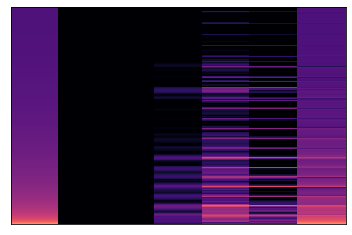

 349/1333 [======>.......................] - ETA: 12s - loss: 6.4216 - accuracy: 0.4972

KeyboardInterrupt: 

In [163]:
input_split = np.concatenate((clean_split[:,:], white_split[:,:]))
input_split_label = np.concatenate((np.ones((clean_split.shape[0], 1)), np.zeros((white_split.shape[0], 1))))

# display a sample ##############
input_test0 = np.reshape(clean_split[0, :], (1, clean_split.shape[1]))
input_test1 = np.reshape(clean_split[1, :], (1, clean_split.shape[1]))
input_test2 = np.reshape(clean_split[2, :], (1, clean_split.shape[1]))
b1 = np.reshape(input_test0.T, (clean_split.shape[1],))
b2 = np.reshape(input_test1.T, (clean_split.shape[1],))
b3 = np.reshape(input_test2.T, (clean_split.shape[1],))
b = np.concatenate((b1, b2, b3))
#################################
c, t, Vxx_input_test = stft(b, fs=samplerate, nperseg=nperseg)
displaySpectrogram(Vxx_input_test)
plt.show()

for i in range(10):
    gan.fit(input_split, input_split_label, batch_size=16)
    output_test0 = g.predict(input_test0)
    output_test1 = g.predict(input_test1)
    output_test2 = g.predict(input_test2)
    o1 = np.reshape(output_test0.T, (white_split.shape[1],))
    o2 = np.reshape(output_test1.T, (white_split.shape[1],))
    o3 = np.reshape(output_test2.T, (white_split.shape[1],))
    o = np.concatenate((o1, o2, o3))
    c, t, Vxx_test = stft(h, fs=samplerate, nperseg=nperseg)
    displaySpectrogram(Vxx_test)
    plt.show()

In [ ]:
i = [np.reshape(white_split[k, :], (1, white_split.shape[1])) for k in range(25)]
o = [g.predict(i[k]) for k in range(len(i))]
p = [np.reshape(i[k].T, (white_split.shape[1],)) for k in range(len(o))]
q = [np.reshape(o[k].T, (white_split.shape[1],)) for k in range(len(o))]


a = np.concatenate(p)
b = np.concatenate(q)
Audio(a, rate=samplerate)

In [ ]:
Audio(b, rate=samplerate)